## My team project focuses on using the [ViruGhan python package](https://kshitijrajsharma.github.io/virtughan/) designed for geospatial applications. In this notebook, I employed the rasterio library, Microsoft Planetary API, and PySTAC to compute NDVI from Sentinel-2 COGs for Bucharest, Romania, in 2024.

# Documnetation of Rasterio library:
[Rasterio](https://fairicube.readthedocs.io/en/latest/gdc_toolkit/rasterio/) is a powerful, open-source Python library designed for reading, writing and manipulating geospatial raster data as I will work with Sentinel 2 datasets. Built on top of the Geospatial Data Abstraction Library (GDAL), Rasterio provides a high-level interface that makes working with geospatial rasters more intuitive and Pythonic. It is widely used by geospatial analysts, remote sensing experts, and developers for handling raster datasets such as satellite imagery, digital elevation models (DEMs) and other grid-based geospatial data.

In [1]:
#install rasterio

!pip  install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 66.7 MB/s eta 0:00:00


## The [Rio-Stac library](https://developmentseed.org/rio-stac/) is a Python package designed to work with SpatioTemporal Asset Catalogs (STAC) and raster data. It simplifies the process of interacting with STAC items and assets, particularly for geospatial raster data.

In [2]:
!pip install rio-stac

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.8/206.8 kB 7.2 MB/s eta 0:00:00


# I will use Planertry computer microsoft API for the datasets
The Microsoft Planetary Computer is a platform that lets users leverage the power of the cloud to accelerate environmental sustainability and Earth science.

The Planetary Computer consists of three major components:



*   The [Data Catalog](https://planetarycomputer.microsoft.com/catalog), which includes petabytes of data about Earth systems, hosted on Azure and made available to users for free.
*   [APIs](https://planetarycomputer.microsoft.com/docs/reference/stac/) that allow users to search for the data they need across space and time.


*   [Applications](https://planetarycomputer.microsoft.com/applications), that put the Planetary Computer platform to work for environmental sustainability.










### I installed [Pystac-clinet](https://pystac-client.readthedocs.io/en/latest/) Python package for working with STAC Catalogs and APIs that conform to the STAC and STAC API specs in a seamless way. PySTAC Client builds upon PySTAC through higher-level functionality and ability to leverage STAC API search endpoints.

In [3]:
!pip install pystac-client planetary-computer matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.8 MB/s eta 0:00:00


## Why Bucharest? I was just there those days doing my BIP, and it has a good vegetation area.

/usr/local/lib/python3.11/dist-packages/pystac_client/item_search.py:881: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


Using Sentinel-2 scene from: 2024-04-14
Shapes after downsample: (2745, 2745) (2745, 2745) (2745, 2745) (2745, 2745)
Red  min/max: 0.0 15875.0
Green min/max: 0.0 15876.0
Blue  min/max: 0.0 16708.0
NIR   min/max: 82.0 16327.0
NDVI valid pixels: 7535025 / 7535025
NDVI min/max: -0.87958884 1.0


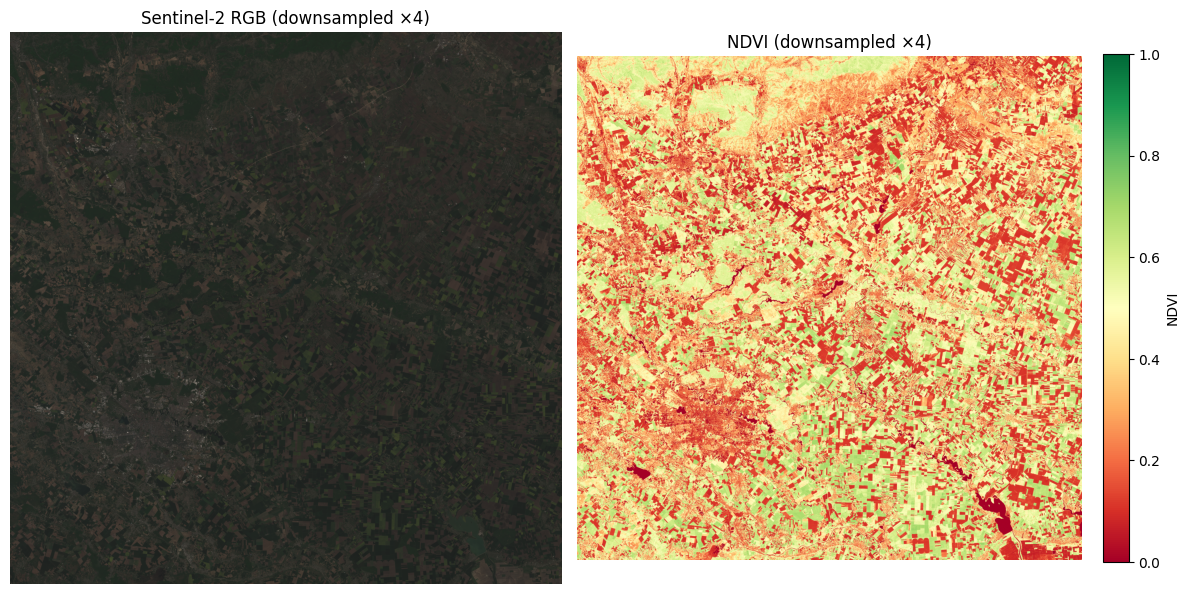

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from pystac_client import Client
import planetary_computer
import os

# 1. Connect to STAC and search for one Sentinel-2 L2A in April 2024 over Bucharest
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

bbox = [26.05, 44.38, 26.15, 44.48]    # Bucharest AOI
date_range = "2024-04-01/2024-04-30"
cloud_cover = 30

search = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=bbox,
    datetime=date_range,
    query={"eo:cloud_cover": {"lt": cloud_cover}},
    max_items=1
)

items = list(search.get_items())
if len(items) == 0:
    raise Exception("No suitable Sentinel-2 items found. Adjust date, AOI, or cloud threshold.")

item = items[0]
print("Using Sentinel-2 scene from:", item.datetime.strftime("%Y-%m-%d"))

# 2. Sign the item to open COG URLs directly
item = planetary_computer.sign(item)

from rasterio.enums import Resampling

def read_band_downsample(href, factor=4):
    """
    downsample the images as I faced memory crash error
    """
    with rasterio.open(href) as src:
        new_height = src.height // factor
        new_width  = src.width  // factor

        arr = src.read(
            1,
            out_shape=(new_height, new_width),
            resampling=Resampling.bilinear
        ).astype("float32")

        transform = src.transform * src.transform.scale(
            (src.width  / new_width),
            (src.height / new_height)
        )

        meta = src.meta.copy()
        meta.update({
            "height": new_height,
            "width": new_width,
            "transform": transform
        })

    return arr, meta

# Read each band at 1/4 resolution
blue, blue_meta   = read_band_downsample(item.assets["B02"].href, factor=4)
green, _          = read_band_downsample(item.assets["B03"].href, factor=4)
red, red_meta     = read_band_downsample(item.assets["B04"].href, factor=4)
nir, _            = read_band_downsample(item.assets["B08"].href, factor=4)

print("Shapes after downsample:", red.shape, green.shape, blue.shape, nir.shape)
print("Red  min/max:",   np.nanmin(red),   np.nanmax(red))
print("Green min/max:",  np.nanmin(green), np.nanmax(green))
print("Blue  min/max:",  np.nanmin(blue),  np.nanmax(blue))
print("NIR   min/max:",  np.nanmin(nir),   np.nanmax(nir))

# Compute NDVI on downsampled arrays
np.seterr(divide="ignore", invalid="ignore")
ndvi = (nir - red) / (nir + red)
ndvi = np.where((nir + red) == 0, np.nan, ndvi)

print("NDVI valid pixels:", np.count_nonzero(~np.isnan(ndvi)), "/", ndvi.size)
print("NDVI min/max:", np.nanmin(ndvi), np.nanmax(ndvi))

# Build a downsampled RGB composite and normalize as Sentinel-2 reflectance is scaled by 10 000
rgb = np.stack([red, green, blue], axis=-1)
rgb_disp = np.clip(rgb / 10000.0, 0, 1)

# Plot downsampled RGB and NDVI side by side
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(rgb_disp)
plt.title("Sentinel-2 RGB (downsampled ×4)")
plt.axis("off")

plt.subplot(1, 2, 2)
nd = plt.imshow(ndvi, cmap="RdYlGn", vmin=0, vmax=1)
plt.title("NDVI (downsampled ×4)")
plt.axis("off")
plt.colorbar(nd, fraction=0.046, pad=0.04, label="NDVI")

plt.tight_layout()
plt.show()

### I am not satisfied about this result so I used percentile stretch
Firstly, Instead of dividing by an arbitrary fixed value (10 000) and clipping, the percentile stretch maps the darkest 2 % → 0 and brightest 2 % → 1. That automatically adapts to the dynamic range of my tile.

Secondly, I adjusted NDVI Range [−1, +1] so by using vmin=-1, vmax=1, it ensures that I can see the full negative‐to‐positive NDVI range. Previously, everything < 0 was mapped to 0 (pure red), giving the illusion of no “blue” or “brown” areas.

In [4]:
# Compute a 2–98 percentile stretch on each band individually
def stretch_pct(band_array, pct_low=2, pct_high=98):
    """Linearly stretch 'band_array' so that the [pct_low,pct_high] percentiles map to [0,1]."""
    lo = np.nanpercentile(band_array, pct_low)
    hi = np.nanpercentile(band_array, pct_high)
    stretched = (band_array - lo) / (hi - lo)
    return np.clip(stretched, 0, 1)

# Apply the stretch to each band separately:
red_st   = stretch_pct(red,   pct_low=2, pct_high=98)
green_st = stretch_pct(green, pct_low=2, pct_high=98)
blue_st  = stretch_pct(blue,  pct_low=2, pct_high=98)

# Stack into an RGB display array:
rgb_disp = np.stack([red_st, green_st, blue_st], axis=-1)


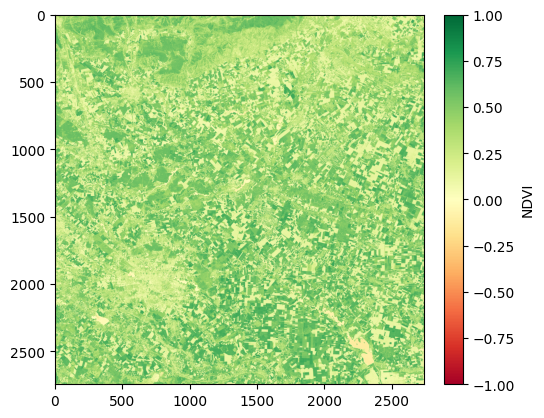

In [5]:
# Use vmin=-1, vmax=1 so negative NDVI shows up:
nd = plt.imshow(ndvi, cmap="RdYlGn", vmin=-1, vmax=1)
plt.colorbar(nd, fraction=0.046, pad=0.04, label="NDVI")


### Side by Side Results

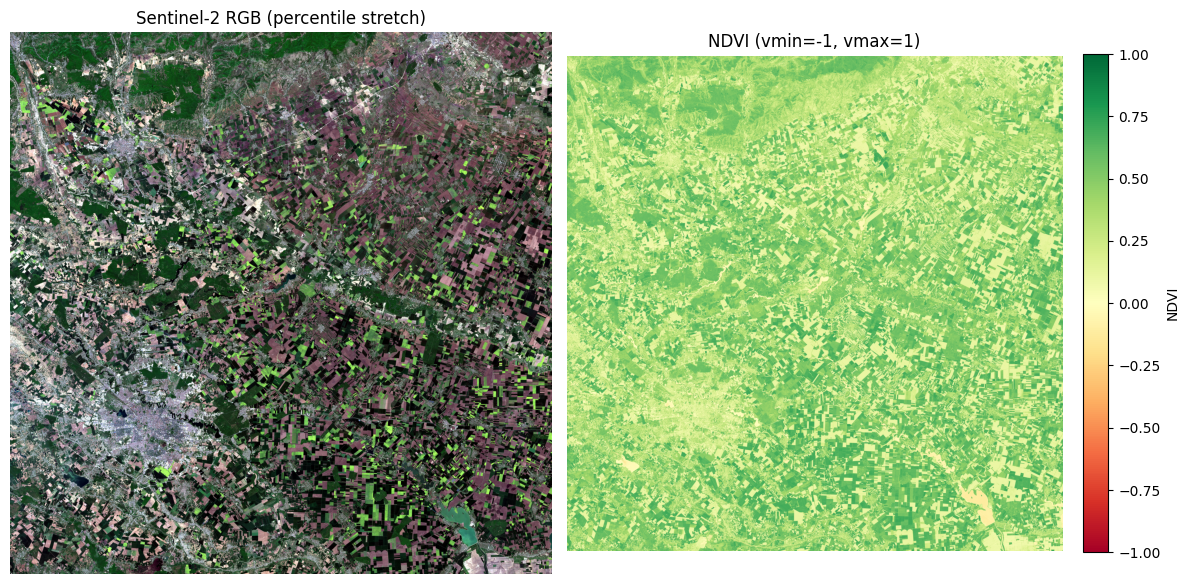

In [7]:
# Compute NDVI (same as before)
np.seterr(divide="ignore", invalid="ignore")
ndvi = (nir - red) / (nir + red)
ndvi = np.where((nir + red) == 0, np.nan, ndvi)

# Plot RGB and NDVI side by side with full NDVI range
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(rgb_disp)
plt.title("Sentinel-2 RGB (percentile stretch)")
plt.axis("off")

plt.subplot(1, 2, 2)
nd = plt.imshow(ndvi, cmap="RdYlGn", vmin=-1, vmax=1)
plt.title("NDVI (vmin=-1, vmax=1)")
plt.axis("off")
plt.colorbar(nd, fraction=0.046, pad=0.04, label="NDVI")

plt.tight_layout()
plt.show()


### Save the results

In [9]:
import os
Sahar_A3 = "/content/drive/MyDrive/A3"
os.makedirs(Sahar_A3, exist_ok=True)

ndvi_meta = red_meta.copy()
ndvi_meta.update({
    "driver": "GTiff",
    "dtype": "float32",
    "count": 1,
    "nodata": np.nan
})

acq_date = item.datetime.date().strftime("%Y-%m-%d")
ndvi_tif_path = os.path.join(Sahar_A3, f"ndvi_bucharest_{acq_date}.tif")

with rasterio.open(ndvi_tif_path, "w", **ndvi_meta) as dst:
    dst.write(ndvi.astype("float32"), 1)

print("Saved NDVI GeoTIFF to Drive:", ndvi_tif_path)



Saved NDVI GeoTIFF to Drive: /content/drive/MyDrive/A3/ndvi_bucharest_2024-04-14.tif
